spooky_author.png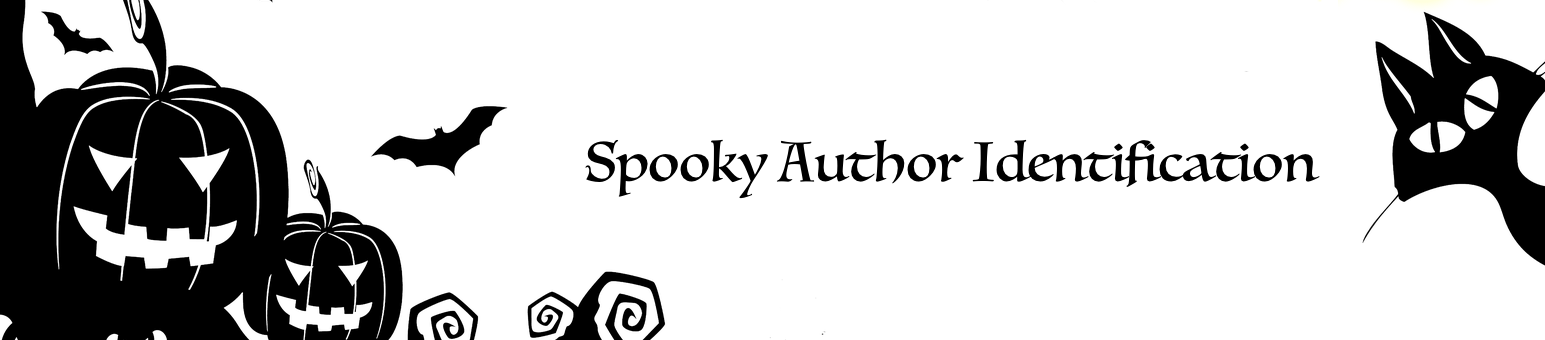

The competition dataset contains text from works of fiction written by spooky authors of the public domain: Edgar Allan Poe, HP Lovecraft and Mary Shelley. The data was prepared by chunking larger texts into sentences using CoreNLP's MaxEnt sentence tokenizer, so you may notice the odd non-sentence here and there. Your objective is to accurately identify the author of the sentences in the test set.

**File descriptions**

    train.csv - the training set
    test.csv - the test set
    sample_submission.csv - a sample submission file in the correct format

**Data fields**

    id - a unique identifier for each sentence
    text - some text written by one of the authors
    author - the author of the sentence (EAP: Edgar Allan Poe, HPL: HP Lovecraft; MWS: Mary Wollstonecraft Shelley)

### Data Exploration
We begin with looking into the data..

In [41]:
wr_dict = {'EAP': 'Edgar Allan Poe', 'HPL': 'HP Lovecraft', 'MWS': 'Mary Wollstonecraft Shelley'}
import json
from collections import Counter
import pandas as pd
import spacy
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")

nlp = spacy.load('en')

from wordcloud import WordCloud, STOPWORDS
from itertools import chain

In [3]:
DATA_DIR = '/Users/ik/Data/spook/'

In [4]:
train_data = pd.read_csv(DATA_DIR + 'train.csv', dtype=str)

In [5]:
Counter(train_data.author)

Counter({'EAP': 7900, 'HPL': 5635, 'MWS': 6044})

### Edgar Allan Poe
* The Cask of Amontillado - http://www.gutenberg.org/ebooks/1063.txt.utf-8

* The Fall of the House of Usher - http://www.gutenberg.org/ebooks/932.txt.utf-8

* The Masque of the Red Death - http://www.gutenberg.org/ebooks/1064.txt.utf-8

* The Raven - http://www.gutenberg.org/ebooks/17192.txt.utf-8

* The Works of Edgar Allan Poe — Volume 1 - http://www.gutenberg.org/files/2147/2147-0.txt

* The Works of Edgar Allan Poe — Volume 2 - http://www.gutenberg.org/files/2148/2148-0.txt
* The Works of Edgar Allan Poe — Volume 3 - http://www.gutenberg.org/files/2149/2149-0.txt
* The Works of Edgar Allan Poe — Volume 4 - http://www.gutenberg.org/files/2150/2150-0.txt
* The Works of Edgar Allan Poe — Volume 5 - http://www.gutenberg.org/files/2151/2151-0.txt

### HP Lovecraft
* The Dunwich Horror - http://www.gutenberg.org/ebooks/50133.txt.utf-8
* The Shunned House - http://www.gutenberg.org/ebooks/31469.txt.utf-8
* Writings in the United Amateur, 1915-1922 - http://www.gutenberg.org/ebooks/30637.txt.utf-8

### Mary Wollstonecraft Shelley
* Frankenstein - http://www.gutenberg.org/files/41445/41445-0.txt
* Mathilda - http://www.gutenberg.org/ebooks/15238.txt.utf-8
* The Last Man - http://www.gutenberg.org/ebooks/18247.txt.utf-8
* Proserpine and Midas - http://www.gutenberg.org/ebooks/6447.txt.utf-8

In [6]:
train_data.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [45]:
wc = WordCloud(stopwords=STOPWORDS, mask=mask1)

In [43]:
mask1 = np.array(Image.open('Inkblot.svg.png'))

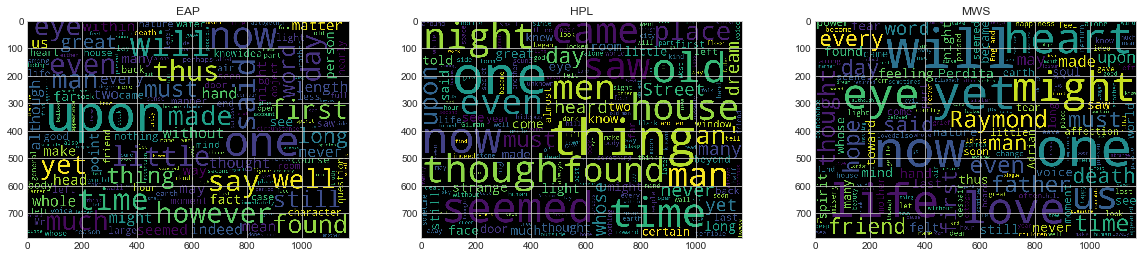

In [46]:
clouds = []
fig, axes = plt.subplots(1,3)
fig.set_size_inches(20,4)

for i, writer in enumerate(('EAP', 'HPL', 'MWS')):
    axes[i].imshow(wc.generate(" ".join([w for w in chain(train_data[train_data.author==writer].text)])))
    axes[i].set_title(writer)